j = 0


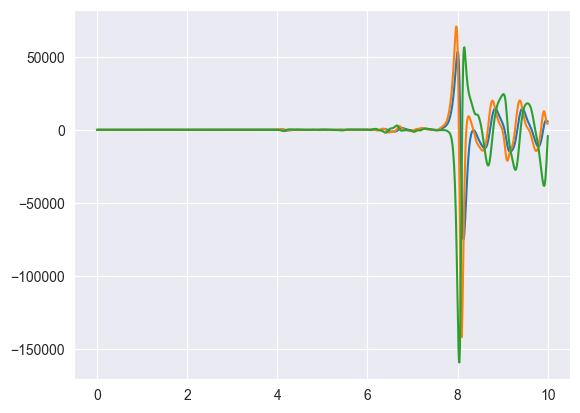

In [2]:
from numba import njit
from pylab import *
from scipy.integrate import solve_ivp

sigma = 15
beta = 8/3
rho = 28

T = 10
N = 1000
h = T/N # should be around 0.01

@njit
def f(t, x):
    y = empty(3, dtype=float64)
    y[0] = sigma * (x[1] - x[0])
    y[1] = rho*x[0] - x[1] - x[0]*x[2]
    y[2] = x[0]*x[1] - beta*x[2]
    return y

@njit
def fDf(x):
    y = empty(6, dtype=float64)
    y[0] = sigma * (x[1] - x[0])
    y[1] = rho*x[0] - x[1] - x[0]*x[2]
    y[2] = x[0]*x[1] - beta*x[2]
    y[3] = sigma * (x[4] - x[3])
    y[4] = (rho-x[2])*x[3] - x[4] - x[0]*x[5]
    y[5] = x[1]*x[3] + x[0]*x[4] - beta*x[5]
    return y

@njit
def rk_integrate(x):
    sol = empty((N+1, 6))
    sol[0] = x
    for i in range(N):
        k1 = h * fDf(x)
        k2 = h * fDf(x + 0.5*k1)
        k3 = h * fDf(x + 0.5*k2)
        k4 = h * fDf(x + k3)
        x += (k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
        sol[i+1] = x
    return sol


x0 = (1,2,3)
sol0 = solve_ivp(f, [0,200], x0)

theta = 3*pi/4
deltaf = array((cos(theta), sin(theta), 0))
x = r_[sol0.y[:,-1], deltaf]

M = 10000
response = zeros((N+1, 3))

for j in range(M):
    response += rk_integrate(x)[:,3:]
    if j%1000 == 0:
        print (f"j = {j}")
        #print (f"j = {j}, response = {response/(j+1)}")
    x[3:] = deltaf

response /= M

figure()
tt = linspace(0, T, N+1)
plot(tt, response)

show()

